<a href="https://colab.research.google.com/github/bethinaveen23/EXPLAINABLE-AI/blob/main/Aissgnment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Setup: imports, load data, and helper paths
import os
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
os.makedirs('iris_explainability_outputs', exist_ok=True)

data = load_iris()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')
target_names = data.target_names
print('Dataset loaded: features:', list(X.columns))

Dataset loaded: features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [2]:
# Train RandomForest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'RandomForest accuracy on test set: {acc:.3f}')

RandomForest accuracy on test set: 0.895


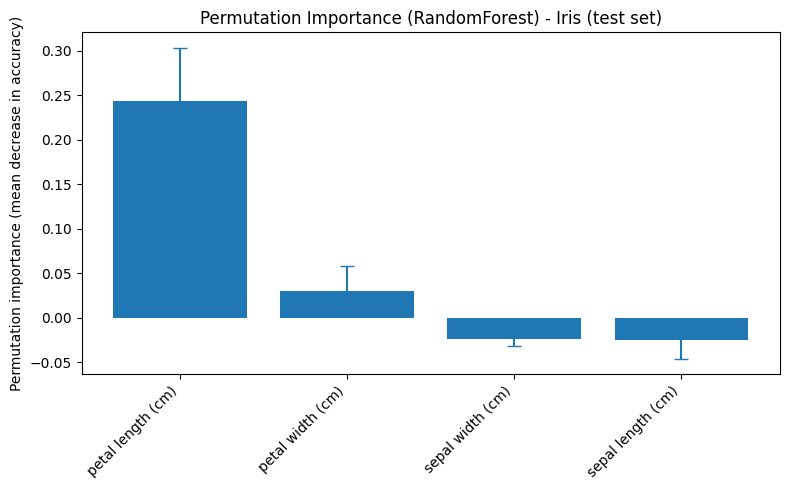

,feature,importance_mean,importance_std
0,petal length (cm),0.243860,0.059598
1,petal width (cm),0.029825,0.027795
2,sepal width (cm),-0.023684,0.007895
3,sepal length (cm),-0.024561,0.021415


In [3]:
# Permutation Importance
r = permutation_importance(clf, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)
perm_df = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': r.importances_mean,
    'importance_std': r.importances_std
}).sort_values('importance_mean', ascending=False).reset_index(drop=True)

plt.figure(figsize=(8,5))
plt.bar(perm_df['feature'], perm_df['importance_mean'])
plt.errorbar(perm_df['feature'], perm_df['importance_mean'], yerr=perm_df['importance_std'], fmt='none', capsize=5)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Permutation importance (mean decrease in accuracy)')
plt.title('Permutation Importance (RandomForest) - Iris (test set)')
plt.tight_layout()
perm_plot_path = 'iris_explainability_outputs/permutation_importance.png'
plt.savefig(perm_plot_path, bbox_inches='tight')
plt.show()

perm_df

SHAP version: 0.48.0


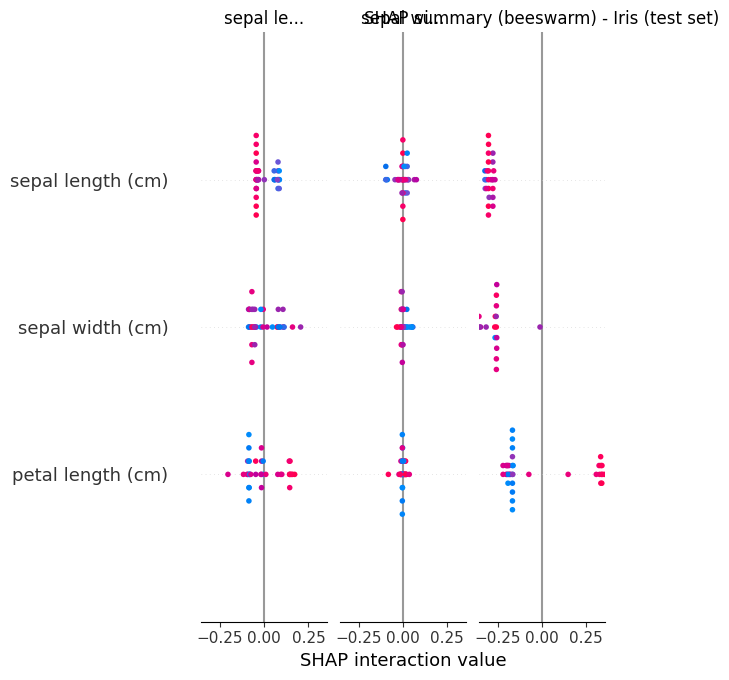

SHAP not available or failed: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.


In [11]:
# SHAP global and local (TreeExplainer) - guarded
try:
    import shap
    print('SHAP version:', shap.__version__)
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X_test)
    # global beeswarm (summary)
    try:
        shap.summary_plot(shap_values, X_test, show=False)
    except Exception:
        shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, show=False)
    plt.title('SHAP summary (beeswarm) - Iris (test set)')
    shap_beeswarm_path = 'iris_explainability_outputs/shap_beeswarm.png'
    plt.savefig(shap_beeswarm_path, bbox_inches='tight')
    plt.show()
    # local Setosa example
    setosa_indices = [i for i, t in enumerate(y_test.tolist()) if t == 0]
    if len(setosa_indices) > 0:
        idx = setosa_indices[0]
        vals = explainer.shap_values(X_test.iloc[idx:idx+1])
        if isinstance(vals, list):
            pred_class = int(clf.predict(X_test.iloc[idx:idx:1])[0])
            single_shap = vals[pred_class][0]
            base_value = explainer.expected_value[pred_class]
        else:
            single_shap = vals[0]
            base_value = explainer.expected_value
            pred_class = int(clf.predict(X_test.iloc[idx:idx+1])[0])
        # waterfall alternative: horizontal bar of contributions
        feat_order = np.argsort(single_shap)
        feats = X_test.columns[feat_order]
        contribs = single_shap[feat_order]
        plt.figure(figsize=(8,4))
        plt.barh(feats, contribs)
        plt.title(f'SHAP local contributions (Setosa sample index {idx}, predicted class {target_names[pred_class]})')
        plt.xlabel('SHAP value (impact on model output)')
        shap_local_path = f'iris_explainability_outputs/shap_local_setosa_idx{idx}.png'
        plt.tight_layout()
        plt.savefig(shap_local_path, bbox_inches='tight')
        plt.show()
    else:
        print('No Setosa in test set - unexpected.')
except Exception as e:
    print('SHAP not available or failed:', e)

LIME not available, using surrogate fallback.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


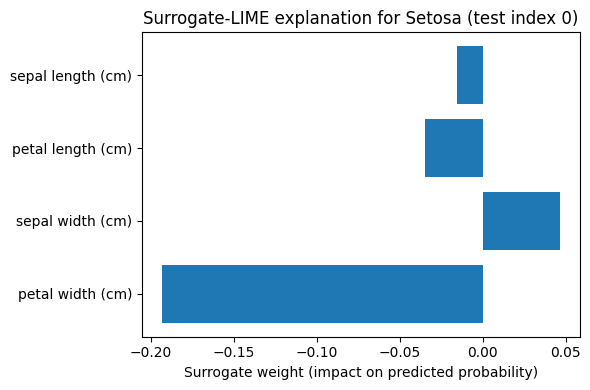

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


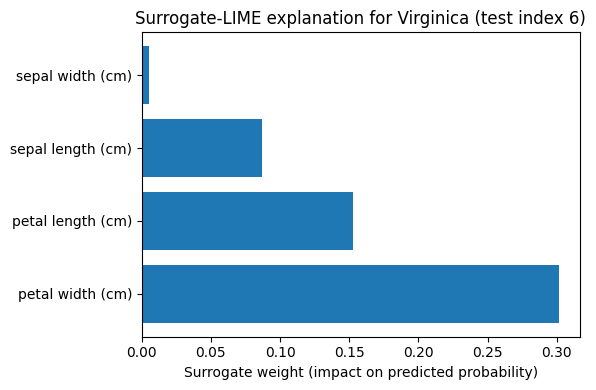

In [10]:
# LIME explanations for two samples - with fallback
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression # Import LinearRegression

try:
    from lime.lime_tabular import LimeTabularExplainer
    lime_available = True
except ImportError:
    print("LIME not available, using surrogate fallback.")
    lime_available = False

def surrogate_lime_explanation(instance, label, idx):
    """Surrogate local explanation mimicking LIME with logistic regression."""
    # Generate perturbed samples
    num_samples = 500
    perturbations = np.random.normal(0, 0.5, size=(num_samples, X_train.shape[1]))
    samples = instance + perturbations
    # samples = np.clip(samples, X_train.min().values, X_train.max().values) # Removed clip

    # Get model predictions (probabilities for the target class)
    # Get the original class label of the instance being explained
    original_class = y_test.iloc[idx]
    # Get the predicted probabilities for all classes for the perturbed samples
    preds_proba = clf.predict_proba(samples)
    # Use the probabilities for the original class as the regression target
    target = preds_proba[:, original_class]


    # Fit local surrogate model (using probabilities as target)
    surrogate = LinearRegression() # Use LinearRegression for continuous target
    surrogate.fit(samples, target)

    # Feature importance
    coefs = surrogate.coef_
    sorted_idx = np.argsort(np.abs(coefs))[::-1]

    # Plot
    plt.figure(figsize=(6, 4))
    plt.barh(X_train.columns[sorted_idx], coefs[sorted_idx])
    plt.xlabel("Surrogate weight (impact on predicted probability)")
    plt.title(f"Surrogate-LIME explanation for {label} (test index {idx})")
    fname = f"iris_explainability_outputs/surrogate_lime_{label.lower()}_idx{idx}.png"
    plt.tight_layout()
    plt.savefig(fname, bbox_inches="tight")
    plt.show()

# Choose one Setosa and one Virginica sample
setosa_idx = None
virginica_idx = None
for i, t in enumerate(y_test.tolist()):
    if t == 0 and setosa_idx is None:
        setosa_idx = i
    if t == 2 and virginica_idx is None:
        virginica_idx = i

chosen = []
if setosa_idx is not None:
    chosen.append(("Setosa", setosa_idx))
if virginica_idx is not None:
    chosen.append(("Virginica", virginica_idx))

for label, idx in chosen:
    if lime_available:
        explainer_lime = LimeTabularExplainer(
            training_data=X_train.values,
            feature_names=X_train.columns.tolist(),
            class_names=list(target_names),
            mode="classification",
            discretize_continuous=True,
            random_state=42,
        )
        exp = explainer_lime.explain_instance(
            X_test.iloc[idx].values,
            clf.predict_proba,
            num_features=4,
        )
        fig = exp.as_pyplot_figure()
        plt.suptitle(f"LIME explanation for {label} (test index {idx})")
        lime_path = f"iris_explainability_outputs/lime_{label.lower()}_idx{idx}.png"
        plt.tight_layout()
        fig.savefig(lime_path, bbox_inches="tight")
        plt.show()
    else:
        surrogate_lime_explanation(X_test.iloc[idx].values, label, idx)